In [2]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google'

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c deep-learning-spring-2025-project-1

 98% 185M/189M [00:06<00:00, 25.2MB/s]
100% 189M/189M [00:06<00:00, 29.1MB/s]


In [ ]:
!unzip deep-learning-spring-2025-project-1.zip

Archive:  deep-learning-spring-2025-project-1.zip
  inflating: cifar-10-python/cifar-10-batches-py/batches.meta  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_1  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_2  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_3  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_4  
  inflating: cifar-10-python/cifar-10-batches-py/data_batch_5  
  inflating: cifar-10-python/cifar-10-batches-py/readme.html  
  inflating: cifar-10-python/cifar-10-batches-py/test_batch  
  inflating: cifar_test_nolabel.pkl  


In [ ]:
!unzip -q deep-learning-spring-2025-project-1.zip -d /content/cifar_data

In [ ]:
!ls /content/cifar_data
!ls /content/cifar_data/cifar-10-python
!ls /content/cifar_data/cifar-10-python/cifar-10-batches-py

cifar-10-python  cifar_test_nolabel.pkl
cifar-10-batches-py
batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [ ]:
import pickle
import numpy as np
from collections import Counter

def unpickle(file):
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

data_dict = unpickle("/content/cifar_data/cifar-10-python/cifar-10-batches-py/data_batch_1")
images = data_dict[b'data']
labels = data_dict[b'labels']

print("images shape:", images.shape)  # (10000, 3072)
print("number of labels:", len(labels))

print("Mean pixel value:", images.mean())
print("Std pixel value:", images.std())

label_counts = Counter(labels)
print(label_counts)  # how many samples per class

images shape: (10000, 3072)
number of labels: 10000
Mean pixel value: 121.04103444010417
Std pixel value: 64.39060047846118
Counter({2: 1032, 6: 1030, 8: 1025, 3: 1016, 0: 1005, 7: 1001, 4: 999, 9: 981, 1: 974, 5: 937})


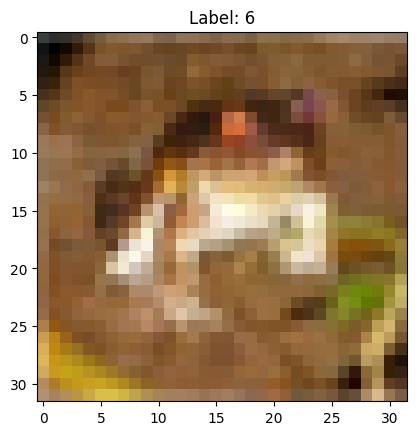

In [ ]:
import matplotlib.pyplot as plt

# first image
img = images[0]
img = img.reshape(3, 32, 32).transpose(1, 2, 0)

# convert from [0,255] to [0,1] for plotting
img = img / 255.0

plt.imshow(img)
plt.title(f"Label: {labels[0]}")
plt.show()

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


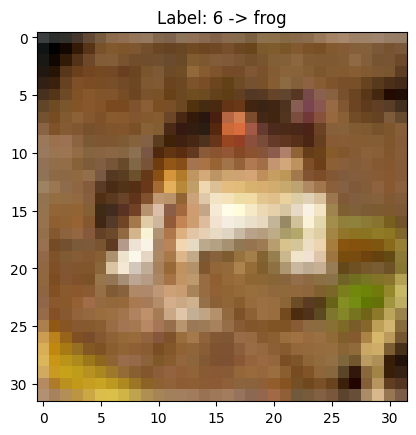

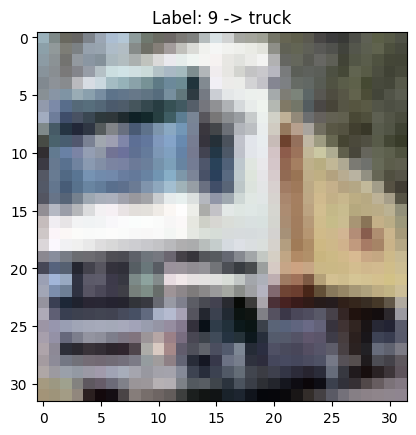

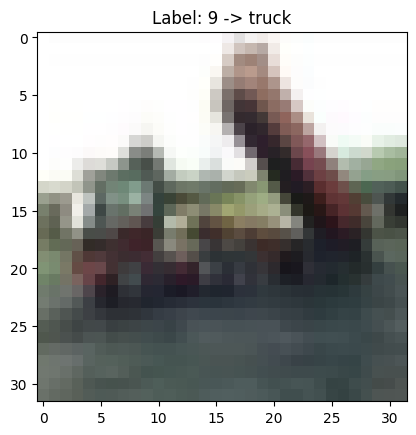

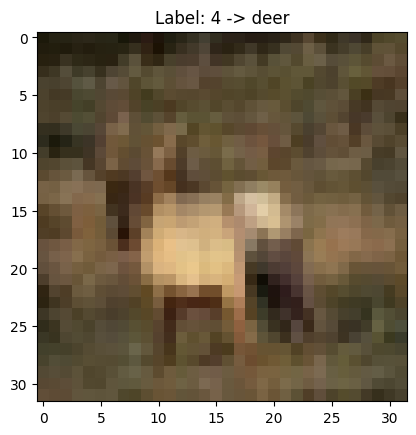

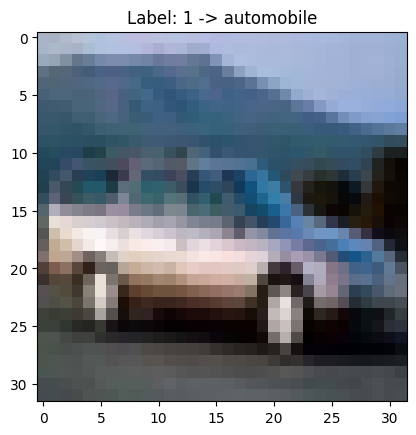

In [ ]:
import matplotlib.pyplot as plt
meta_dict = unpickle("/content/cifar_data/cifar-10-python/cifar-10-batches-py/batches.meta")
label_names = meta_dict[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]

print(label_names)

for i in range(5):
    img = images[i].reshape(3, 32, 32).transpose(1, 2, 0)
    img = img / 255.0

    plt.imshow(img)
    plt.title(f"Label: {labels[i]} -> {label_names[labels[i]]}")
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##########################################################
# Basic Residual Block
##########################################################
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

##########################################################
# A "SmallResNet" Architecture
##########################################################
class SmallResNet(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[2,2,2,2],
                 num_classes=10, base_channels=32):
        """
        Args:
            block:          Residual block type (BasicBlock).
            num_blocks:     List of 4 integers, # of blocks in each layer.
            num_classes:    Number of output classes (10 for CIFAR-10).
            base_channels:  # of channels in first layer. Adjust to control total params.
        """
        super(SmallResNet, self).__init__()
        self.in_planes = base_channels

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)

        # Create 4 stages (layers)
        self.layer1 = self._make_layer(block, base_channels,   num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, base_channels*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, base_channels*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, base_channels*8, num_blocks[3], stride=2)

        # Global average pooling and linear layer
        self.linear = nn.Linear(base_channels*8*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global Average Pooling
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
model = SmallResNet(base_channels=32, num_blocks=[2,2,2,2]).to('cuda')
summary(model, (3, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

Notes:
- conv2d-# : # represents the #'d module in the network based on the librarys internal indexing
- BatchNorm2d-2 = 2D batch normalization layer
- Output shape starts at [-1,32 ,32, 32] and goes to [-1, 256,4,4] => [-1, 10]
  - -1 is the batch dimension
  - 32 is the # of output channels which increases by double to 256
  - 32, 32 is the spatial resolution (height, width), this changes to (16, 16), (8, 8), (4,4) as seen in the convolution demo, also since stride = 2 convolutions bc its halves spatial dimensions
- parameter count = (in channels) * (out channels) * (Kernel height) * (kernel width) + (out_channels if bias=True)
- Basic Block: residual block contains two conv layers + two batchnorm layeres + optional projection if stride/channel differs

- initial convolution layer is set to 3x3 where stride=1 for CIFAR-10 since input images are 32x32, the one provided in the github repo is 7x7 with a stride=2 for ImageNet
Overall ResNet structure: includes four main structures where each stage has 1/2 basic blocks and the convolutions in each block double the channels (32->64->128->256) and reduce spatial dimensions by half since stride=2 is used. Setting base channels to 32 balances the capacity and constraints (but can be tweaked with different values).

- possible changes:
  * experiment with diff # of blocks e.g num_blocks = [3,3,3,3]
  * different base_channel start value instead of 32
  * maybe stronger data augmentation, label smoothing, or advanced optimizers
  * separate validation set / cross-validation to confirm hyperparameter choices

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

def train_model(model, trainloader, testloader, epochs=50, lr=0.1, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # zero outs gradients
            outputs = model(inputs) # forward pass : model outsputs predictions
            loss = criterion(outputs, labels) # computes the loss
            loss.backward() #backward pass to compute the gradients
            optimizer.step() #updates the parameters.

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.*correct/total
        scheduler.step()

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs_test, labels_test in testloader:
                inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
                outputs_test = model(inputs_test)
                _, predicted_test = outputs_test.max(1)
                total_test += labels_test.size(0)
                correct_test += predicted_test.eq(labels_test).sum().item()

        test_acc = 100.*correct_test/total_test

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Loss: {running_loss/len(trainloader):.3f}, "
              f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return model

if __name__ == "__main__":
    # Transforms and dataset
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    model = SmallResNet(base_channels=32, num_blocks=[2,2,2,2], num_classes=10)
    # training
    trained_model = train_model(model, trainloader, testloader, epochs=50, lr=0.1, device='cuda')


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Loss: 1.674, Train Acc: 38.05%, Test Acc: 43.39%
Epoch [2/50], Loss: 1.205, Train Acc: 56.40%, Test Acc: 61.53%
Epoch [3/50], Loss: 0.914, Train Acc: 67.65%, Test Acc: 69.38%
Epoch [4/50], Loss: 0.757, Train Acc: 73.37%, Test Acc: 74.17%
Epoch [5/50], Loss: 0.667, Train Acc: 76.84%, Test Acc: 75.34%
Epoch [6/50], Loss: 0.610, Train Acc: 78.93%, Test Acc: 75.88%
Epoch [7/50], Loss: 0.578, Train Acc: 80.02%, Test Acc: 77.91%
Epoch [8/50], Loss: 0.549, Train Acc: 81.06%, Test Acc: 78.58%
Epoch [9/50], Loss: 0.528, Train Acc: 82.08%, Test Acc: 76.68%
Epoch [10/50], Loss: 0.515, Train Acc: 82.40%, Test Acc: 79.24%
Epoch [11/50], Loss: 0.500, Train Acc: 82.69%, Test Acc: 79.64%
Epoch [12/50], Loss: 0.491, Train Acc: 83.09%, Test Acc: 81.79%
Epoch [13/50], Loss: 0.482, Train Acc: 83.52%, Test Acc: 79.66%
Epoch [14/50], Loss: 0.468, Train Acc: 83.87%, Test Acc: 81.49%
Epoch [15/50], Loss: 0.458, Train Acc

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total params:", count_params(model))

Total params: 2797610


modifiying the small resnet and using a medium sized resnet with deeper layers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

def count_params(model):
    """Return the number of trainable parameters in `model`."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy(outputs, labels):
    """Compute the batch accuracy."""
    _, preds = outputs.max(1)
    return preds.eq(labels).sum().item() / labels.size(0)


In [ ]:
# Residual Blocks
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        # If stride != 1 or channels mismatch, apply 1×1 conv to match shapes
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes*self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes*self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# Medium Resnet
class MediumResNet(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[3,3,3,3],
                 base_channels=48, num_classes=10):
        """
        Args:
            block (nn.Module): Residual block type (BasicBlock).
            num_blocks (list): Number of blocks in each of the 4 layers.
            base_channels (int): Channels in the first layer. This scales up each layer.
            num_classes (int): Output dimension for classification.
        """
        super(MediumResNet, self).__init__()
        self.in_planes = base_channels

        # Initial conv: 3×3 with base_channels
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)

        # Create 4 layers
        self.layer1 = self._make_layer(block, base_channels,   num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, base_channels*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, base_channels*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, base_channels*8, num_blocks[3], stride=2)

        # Classifier: global average pool -> linear
        self.linear = nn.Linear(base_channels*8*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling to 1×1
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
# Data Loading & Augmentation
def get_cifar10_loaders(batch_size=128, num_workers=2):
    """
    Returns trainloader, testloader for CIFAR-10 with standard augmentation.
    """
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, testloader


In [ ]:
# Training

def train_model(model, trainloader, testloader,
                epochs=50, lr=0.1, step_size=25, gamma=0.1,
                device='cuda'):
    """
    Train and evaluate the model on CIFAR-10.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_correct += (outputs.max(1)[1] == labels).sum().item()
            total += labels.size(0)

        train_acc = 100.0 * running_correct / total
        train_loss = running_loss / total

        # Evaluate
        test_acc, test_loss = evaluate_model(model, testloader, criterion, device)

        # Scheduler step
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%")

    return model

def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.max(1)[1] == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return acc, avg_loss

In [ ]:
if __name__ == "__main__":
    # Get data loaders
    trainloader, testloader = get_cifar10_loaders(batch_size=128, num_workers=2)

    # Instantiate the ResNet
    model = MediumResNet(
        block=BasicBlock,
        num_blocks=[3,3,3,3],  # can tweak for more/less depth
        base_channels=48,      # can increase if still under 5M
        num_classes=10
    )

    # Check parameter count
    pcount = count_params(model)
    print(f"Total trainable parameters: {pcount}")

    # see layer-by-layer summary command:
    # summary(model, (3, 32, 32), device='cpu')  # or device='cuda'

    # Train
    trained_model = train_model(
        model, trainloader, testloader,
        epochs=50, lr=0.1, step_size=25, gamma=0.1,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

Files already downloaded and verified
Files already downloaded and verified
Total trainable parameters: 9816442
Epoch [1/50], Train Loss: 2.011, Train Acc: 28.93%, Test Loss: 1.666, Test Acc: 37.84%
Epoch [2/50], Train Loss: 1.542, Train Acc: 43.57%, Test Loss: 1.388, Test Acc: 47.94%
Epoch [3/50], Train Loss: 1.263, Train Acc: 54.24%, Test Loss: 1.150, Test Acc: 58.64%
Epoch [4/50], Train Loss: 1.026, Train Acc: 64.00%, Test Loss: 1.124, Test Acc: 60.90%
Epoch [5/50], Train Loss: 0.869, Train Acc: 69.36%, Test Loss: 1.058, Test Acc: 65.37%
Epoch [6/50], Train Loss: 0.738, Train Acc: 74.08%, Test Loss: 0.741, Test Acc: 74.34%
Epoch [7/50], Train Loss: 0.653, Train Acc: 77.26%, Test Loss: 0.757, Test Acc: 74.30%
Epoch [8/50], Train Loss: 0.601, Train Acc: 79.36%, Test Loss: 0.620, Test Acc: 78.97%
Epoch [9/50], Train Loss: 0.561, Train Acc: 80.56%, Test Loss: 0.635, Test Acc: 78.96%
Epoch [10/50], Train Loss: 0.537, Train Acc: 81.54%, Test Loss: 0.796, Test Acc: 73.46%
Epoch [11/50], Tr

Note: obviously this bypasses the 5 million limit but I was just testing base_channels = 48 and num_blocks = [3,3,3,3]. each time the channels are doubled across the four layers, the network grows from 48->96->192->384 so the deeper layers add a lot of convolutional weights.
Basic block mathematically works like (Cin * Cout * 3 * 3) * 2 (two conv layers) + batch norm paramters, multiplying the above over multiple layers exceed the parameter budget.

epoch observations:
- jump around epoch 25-26 where stepLR schedule drops learning rate by gamma=0.1 to 0.01 which causes a boost in performance
- overfitting a little bit by 5%, but 50 epochs is a good #

ways to improve (lessen parameters to <= 50 mil:
- reducing base_channels=32 using [3,3,3,3] blocks
- reducing [3,3,3,3] to [2,2,2,2] blocks which is.a ResNet-18-style with a custom base channel width. less residual blocks mean fewer convolution layers
- make a combo where we can use lower base_channels & lower block width like base_channels = 40 & block_width = [2,2,2,2]

> Also what is learning rate (scheduling)
- adjusting the learning rate during training rather than keeping it fixed.
- choosing a scehdule helps the optimizer converge faster => leads to a higher final accuracy
  - early training: higher learning rate for training model to learn quickly the basic complexities
  - later training: lower learning rate to allow the model to refine its position in the loss landscape which reduces oscillation and improves fine-tuning of weights.
  - this allows for a learning rate drop that is times to lead to a jump in accuracy since the model wil converge effeticely with a smaller step size.
- Currently using StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
  - at every step_size of ephocs (e.g 25), the learning rate is multiplied by gamma (0.1) so initially the LR = 0.1, and then at Epoch 25: LR => 0.01, and Epoch 50: LR => 0.001, etc.

- Other options that are more advances but StepLR is most commonly referenced too in class.
> Cosine Annealing:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
  - The learning rate follows a cosine curve from an initial value (e.g., 0.1) down to a minimum (often near 0) over T_max epochs.
  - The LR decreases more smoothly than StepLR, potentially avoiding abrupt changes that might cause small disruptions in training.
  - Some approaches like CosineAnnealingWarmRestarts periodically reset to a higher LR, letting the model escape local minima multiple times.

> OneCycleLR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1, steps_per_epoch=len(trainloader), epochs=50
)
  - In a single “cycle,” the learning rate first increases from a lower bound to max_lr over some fraction of the total iterations, then decreases back down to a lower bound over the remaining iterations.
  - The initial warm‐up phase helps the model quickly find a good region of the parameter space.
  - The second phase reduces LR, allowing the model to converge more precisely.
  - Often yields very stable and fast convergence, popularized by the “1cycle policy” from Leslie Smith.



  > Different Optimizers
    -  Basic SGD (Stochastic Gradient Descent)
      - w <- w - alpha upside down delta (lower w) Loss
      - delta is the learning rate and upside down delta (lower w) Loss is the gradient of the loss with respect to w
      pros:
        - easy to implement and has a good baseline
      cons:
        - slow convergence, oscialltes or takes small steps in noisy directions
        - needs careful LR tuning since it is sensitive of the choice of learning rate
      - code:
      import torch.optim as optim
      optimizer = optim.SGD(
          model.parameters(),
          lr=0.1  # typical LR for CIFAR-10
      )
    - SGD with Momentum
      - Momentum is an extension of SGD that accumulates an exponentially decaying average of past gradients:
      - v <- beta (lower v) + delta (lower w)(Loss), w <- w - alpha v
      where Beta (B) is the momentum coefficient
      pros:
        - faster convergence since it helps the optimizer move in a perferred direction to dampen oscillations in the gradient
        - esscapes shallow (small) local minima
      cons:
        - requires careful LR since momentum doesnt adapt to the learning rate for each parameter, so LR needs  to be tuned
        - potential overshooting of the minima if the momentum is too high
      - code:
      optimizer = optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,    # typical momentum value
        weight_decay=5e-4  # optional L2 regularization
      )

    - Adam (Adaptive Moment Estimation)
      - maintains first and second moments (mean and variance) of past gradients for each parameter: ( some complicated ass formula) which effectively adapts the learning rate for each parameter based on its gradient history
      pros:
        - adaptive LR as it automatically scales the step size per parameter
        - fast convergence: Often converges more quickly than plain SGD or SGD with momentum, especially in problems with sparse gradients or large parameter counts. (maybe not the best here as 5 mil is theoretically not a lot of param counts)
      cons:
        - generalization: Some studies suggest Adam might generalize slightly worse than tuned SGD with momentum on certain datasets, though this is problem‐dependent.
        - extra hyperparamerts such as beta(1) & beta(2) that might need tuning
      - code:
      optimizer = optim.Adam(
          model.parameters(),
          lr=1e-3,
          weight_decay=1e-4  # optional L2 regularization
      )

  
  # Option A: Basic SGD
  optimizer = optim.SGD(model.parameters(), lr=0.1)

  # Option B: SGD with Momentum
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

  # Option C: Adam
  optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


  > Loss Function
  - cross entropy loss
    - scalar value that quantifies how far off the model's predictions are from the true labels

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1  # The output channels factor

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, planes * self.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # Initial convolution: 3×3 kernel, 64 channels, stride=1 for CIFAR-10
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)

        # Each layer has some number of blocks
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global average pooling + linear classifier
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # initial conv
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pool from e.g. 4×4 → 1×1
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def ResNet34(num_classes=10):
  return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

# etc. for ResNet50, ResNet101, etc.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes*self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class SmallResNet(nn.Module):
    """
    A ResNet-like model that reduces the base channel width from 64 down to e.g. 32,
    to keep total params under ~5M. We still use [2,2,2,2] blocks.
    """
    def __init__(self, block, num_blocks, base_channels=32, num_classes=10):
        super(SmallResNet, self).__init__()
        self.in_planes = base_channels

        # Instead of 3->64, do 3->base_channels
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)

        # layer1: base_channels
        # layer2: base_channels*2
        # layer3: base_channels*4
        # layer4: base_channels*8
        self.layer1 = self._make_layer(block, base_channels,   num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, base_channels*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, base_channels*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, base_channels*8, num_blocks[3], stride=2)

        self.linear = nn.Linear(base_channels*8*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global avg pool
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SmallResNet18(num_classes=10, base_channels=32):
    return SmallResNet(BasicBlock, [2, 2, 2, 2],
                       base_channels=base_channels,
                       num_classes=num_classes)

def SmallResNet19(num_classes=10, base_channels=32):
    return SmallResNet(BasicBlock, [3, 3, 3, 3],
                       base_channels=base_channels,
                       num_classes=num_classes)

def SmallResNet20(num_classes=10, base_channels=40):
    return SmallResNet(BasicBlock, [2, 2, 2, 2],
                       base_channels=base_channels,
                       num_classes=num_classes)

def SmallResNet23(num_classes=10, base_channels=40):
    return SmallResNet(BasicBlock, [2, 2, 2, 2],
                       base_channels=base_channels,
                       num_classes=num_classes)

In [ ]:
model = SmallResNet18(num_classes=10, base_channels=32) # < 5 mil,  ~ 3 mil
print("Param count:", sum(p.numel() for p in model.parameters()))

model2 = SmallResNet20(num_classes=10, base_channels=40) # < 5 mil, ~ 4.36 mil
print("Param count:", sum(p.numel() for p in model2.parameters()))

model3 = SmallResNet23(num_classes=10, base_channels=46) #too big
print("Param count:", sum(p.numel() for p in model3.parameters()))

model4 = SmallResNet19(num_classes=10, base_channels=32) # testing wider layers # < 5 mil, ~ 4.36 mil
print("Param count:", sum(p.numel() for p in model4.parameters()))

Param count: 2797610
Param count: 4368690
Param count: 5775816
Param count: 4366250


In [ ]:
import pickle
import numpy as np
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def unpickle(file):
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

def load_cifar10_training(path):
    """
    path = "/content/cifar_data/cifar-10-python/cifar-10-batches-py"
    Loads data_batch_1..5, concatenates them into a single array.
    Returns:
      images: shape (50000, 3072)
      labels: shape (50000,)
    """
    images_list = []
    labels_list = []
    for i in range(1, 6):
        batch_file = os.path.join(path, f"data_batch_{i}")
        batch_dict = unpickle(batch_file)
        images_list.append(batch_dict[b'data'])
        labels_list.extend(batch_dict[b'labels'])
    images = np.concatenate(images_list, axis=0)  # (50000, 3072)
    labels = np.array(labels_list)                # (50000,)
    return images, labels

def load_cifar10_test(path):
    """
    Loads test_batch, returns images and labels.
    """
    test_file = os.path.join(path, "test_batch")
    batch_dict = unpickle(test_file)
    images = batch_dict[b'data']           # shape (10000, 3072)
    labels = np.array(batch_dict[b'labels'])  # shape (10000,)
    return images, labels

class CustomCIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: shape (N, 3072) NumPy array
        labels: shape (N,) or list
        transform: optional torchvision transforms
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # shape (3072,)
        label = self.labels[idx]

        # reshape to (3, 32, 32)
        img = img.reshape(3, 32, 32).astype("float32")

        # convert to PIL or torch.Tensor
        # We'll convert to torch.Tensor first, then apply transforms if needed
        img = torch.from_numpy(img)

        if self.transform:
            # transforms in PyTorch usually expect a PIL Image or
            # a float Tensor in [0,1]. We'll treat 'img' as a Tensor.
            img = self.transform(img)

        return img, label




In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # back to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_images, train_labels = load_cifar10_training("/content/cifar_data/cifar-10-python/cifar-10-batches-py")
test_images, test_labels   = load_cifar10_test("/content/cifar_data/cifar-10-python/cifar-10-batches-py")

train_dataset = CustomCIFARDataset(
    train_images, train_labels, transform=train_transform
)
test_dataset = CustomCIFARDataset(
    test_images, test_labels, transform=test_transform
)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)


In [ ]:
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet34(num_classes=10).to(device)
print("Parameter count:", sum(p.numel() for p in model.parameters()))


Parameter count: 21282122


In [ ]:
# DOES NOT WORK yet since i changed model => model2
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# StepLR after 25 epochs ( scheduler LR can be modified)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

def train_one_epoch(model2, loader, optimizer, criterion, device):
    model2.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model2, loader, criterion, device):
    model2.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Full training
epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model2, trainloader, optimizer, criterion, device)
    test_loss, test_acc   = evaluate(model2, testloader, criterion, device)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same